In [2]:
# importación de librerías
import numpy as np
import cv2
from matplotlib import pyplot as plt # necesario para mostrar imágenes en jupyter

def mostrar(imagen):
    if len(imagen.shape) == 3:
        img = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        img = imagen
        plt.imshow(img, cmap='Greys_r')
    
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

# Ejercicio 1 - Estimación de la matriz cámara a partir de puntos 3D y sus proyecciones 2D.

## Apartado a - Generar una matriz de cámara finita con valores aleatorios en [0,1]

Para que una matriz defina una cámara debe cumplir las siguientes condiciones:

* Ser una matriz $3 \times 4$.

$$ P_{3\times 4} = [M_{3\times 3} | p_{3 \times 1}]$$

* Que el determinante de la submatriz $M_{3 \times 3}$ sea distinto de cero.

$$ det(M) \neq 0$$

En la función implementada, genero una matriz $3 \times 4$ aleatoria inicial, si no cumple la condición de que su determinante de $M$ sea distinto de cero, vuelvo a generar otra matriz aleatoria, hasta conseguir una que cumpla la condición. La función `random.rand` de _Numpy_ nos asegura números aleatorios en el rango $[0,1]$.

In [3]:
def genera_camara_finita():
    P = np.random.rand(3,4)
    while np.linalg.det(P[:3,:3]) == 0:
        P = np.random.rand(3,4)
    P=P/P[-1,-1]
    return P

P = genera_camara_finita()
P

array([[ 26.80427878,  29.36460605,  14.96294654,   3.29216504],
       [  6.0311387 ,  26.81493439,  10.52982148,  31.70462265],
       [  3.23072257,   2.76501086,   1.08090108,   1.        ]])

## Apartado b - Generar puntos 3D en dos planos distintos ortogonales.

Para que los puntos generados cumplan la condición de pertenecer a dos planos distintos ortogonales deben tener la siguiente forma:

$$\{(0,x_1,x_2)\;y\;(x_2,x_1,0), \qquad\ donde\;x_1 = [0.1,0.1,1]\;y\;x_2=[0.1,0.1,1]\}$$

es decir, tanto $x_1$ como $x_2$ son todos los números desde el $0,1$ hasta el $1$ en intervalos de $0,1$: $0.1, 0.2, 0.3, \cdots 1$.

In [4]:
# función para generar puntos del mundo 3D con coordenadas {(0, x1, x2) y (x2, x1, 0)}. Es decir, una rejilla de puntos
# en dos planos distintos ortogonales. x1=0.1:0.1:1 y x2=0.1:0.1:1 significa que tenemos que generar valores de x1 y x2
# desde 0.1 a 1 y que aumenten de 0.1 en 0.1.
def genera_puntos_planos_ortogonales_distintos():
    # posibles valores para x1 y x2
    x1 = x2 = np.arange(start=0.1,stop=1,step=0.1,dtype=np.float32)
    # generamos un conjunto de puntos con todas las combinaciones de (x1,x2)
    conjunto = np.concatenate(np.array(np.meshgrid(x1,x2)).T)
    # y le añadimos una columna de ceros al principio
    zeros_vector = np.zeros(conjunto.shape[0])
    conjunto1 = np.hstack((zeros_vector[..., None], conjunto))
    # y otra al final
    conjunto2 = np.hstack((conjunto, zeros_vector[...,None]))

    return np.concatenate((conjunto1, conjunto2))

p = genera_puntos_planos_ortogonales_distintos()
p

array([[ 0.        ,  0.1       ,  0.1       ],
       [ 0.        ,  0.1       ,  0.2       ],
       [ 0.        ,  0.1       ,  0.30000001],
       [ 0.        ,  0.1       ,  0.40000001],
       [ 0.        ,  0.1       ,  0.5       ],
       [ 0.        ,  0.1       ,  0.60000002],
       [ 0.        ,  0.1       ,  0.70000005],
       [ 0.        ,  0.1       ,  0.80000001],
       [ 0.        ,  0.1       ,  0.90000004],
       [ 0.        ,  0.2       ,  0.1       ],
       [ 0.        ,  0.2       ,  0.2       ],
       [ 0.        ,  0.2       ,  0.30000001],
       [ 0.        ,  0.2       ,  0.40000001],
       [ 0.        ,  0.2       ,  0.5       ],
       [ 0.        ,  0.2       ,  0.60000002],
       [ 0.        ,  0.2       ,  0.70000005],
       [ 0.        ,  0.2       ,  0.80000001],
       [ 0.        ,  0.2       ,  0.90000004],
       [ 0.        ,  0.30000001,  0.1       ],
       [ 0.        ,  0.30000001,  0.2       ],
       [ 0.        ,  0.30000001,  0.300

## Apartado c - Proyectar los puntos 3D generados con la cámara P simulada

Para calcular la proyección de un 3D con una cámara $P$ debemos multiplicar la cámara por el punto:

$$x_{3 \times 1} = P_{3 \times 4} \cdot X_{4 \times 1}$$

Debemos convertir el punto 3D $X$ a coordenadas homogéneas (añadiéndole un $1$ como última coordenada) para poder multiplicarlo por la matriz de la cámara. Una vez hecha la multiplicación, obtenemos un vector $x$ con tres elementos, pero un punto 2D sólo tiene dos coordenadas, por lo que debemos eliminar el último elemento del vector:

$$x_x = \frac{x_x}{x_z} \qquad\ x_y = \frac{x_y}{x_z}$$

In [5]:
# función que dado un punto del mundo calcula sus coordenadas de proyección de la cámara.
# Debemos añadirle al punto x un elemento 1 para poder multiplicarlo por la matriz cámara.
camera_projection = lambda x, P: P.dot(np.hstack((x,[1])))

# Proyectar el conjunto de puntos del mundo con la cámara simulada y obtener las coordenadas píxel de su proyección
def proyecta_puntos_en_plano(camara, puntos):
    # definimos el array en el que guardaremos las coordenadas píxel de los puntos
    conjunto = np.zeros(puntos.shape)
    # iteramos sobre el array de puntos del mundo para proyectar los puntos
    for i in range(puntos.shape[0]):
        conjunto[i] = camera_projection(x=puntos[i], P=camara)

    # calculamos las coordenadas píxel diviendo la coordenada x e y por la coordenada z
    coords_pixel = np.zeros((puntos.shape[0], 2))
    for i in range(puntos.shape[0]):
        z = conjunto[i,2]
        coords_pixel[i,0] = conjunto[i,0]/z
        coords_pixel[i,1] = conjunto[i,1]/z

    return coords_pixel

c = proyecta_puntos_en_plano(camara=P, puntos=p)
c

array([[  5.57920661,  25.59535139],
       [  6.17761808,  24.4473353 ],
       [  6.6952156 ,  23.45435587],
       [  7.14733418,  22.58699383],
       [  7.54565985,  21.82283019],
       [  7.89925407,  21.14448115],
       [  8.21525107,  20.53826008],
       [  8.49934449,  19.99324411],
       [  8.75613399,  19.50060904],
       [  6.41829541,  22.94911126],
       [  6.87191761,  22.14219062],
       [  7.27330228,  21.42819213],
       [  7.63098132,  20.79193891],
       [  7.95172466,  20.22138831],
       [  8.24097273,  19.70686271],
       [  8.50314736,  19.24049639],
       [  8.74187956,  18.81583038],
       [  8.96017919,  18.4275106 ],
       [  7.01790266,  21.05812573],
       [  7.37852971,  20.46018722],
       [  7.70295965,  19.92226541],
       [  7.99638178,  19.43575617],
       [  8.26303881,  18.99362487],
       [  8.50643322,  18.59006422],
       [  8.72948179,  18.22023803],
       [  8.93463318,  17.88008629],
       [  9.12395859,  17.56617485],
 

## Apartado d - Implementar el algoritmo DLT

Dados unos puntos 3D, $X$ y sus proyecciones en 2D, $x$, queremos estimar la matriz de la cámara $P$.

$$ x_i = P \cdot X_i \qquad\ i = 1, \ldots, N $$

Cada punto tiene $x$ tiene 3 ecuaciones distintas:

$$ \left[ 
    \begin{array}{ccc}
    0^T & -X_i^T & y_i\cdot X_i^T \\
    X_i^T & 0^T & -x_i\cdot X_i^T \\
    -y_i \cdot X_i^T & x_i \cdot X_i^T & 0^T
    \end{array} \right] \left( \begin{array}{c}
    P^1 \\
    P^2 \\
    P^3
    \end{array} \right) = 0$$

donde cada $P^{iT}$ es un vector de 4 elementos que contiene la $i$-ésima fila de $P$. Debido a que estas tres ecuaciones son linealmente dependientes, podemos quedarnos únicamente con las dos primeras:

$$ \underbrace{\left[ 
    \begin{array}{cccc}
    X_i^T & 0^T & -x_i\cdot X_i^T & -x_i\\
    0^T & X_i^T & -y_i\cdot X_i^T & -y_i
    \end{array} \right]}_{M_i} \left( \begin{array}{c}
    P^1 \\
    P^2 \\
    P^3 \\
    1
    \end{array} \right) = 0$$
    
Para cada punto calcularemos su matriz $M_i$ y haremos una matriz $M$ con un total de $2N$ filas. Como mínimo, $N \geq 6$, ya que la matriz $P$ tiene 12 elementos y (ignorando la escala) 11 grados de libertad, por lo que debemos tener 11 ecuaciones para resolver $P$, debido a que cada punto nos da dos ecuaciones, necesitamos como mínimo $5,5$ puntos.

Una vez hayamos obtenido la matriz $M$, pasaremos a calcular su __descomposición en valores singulares__:

$$ SVD(M) = USV^T $$

La matriz $S$ contiene los autovalores de $M$ y $V$, los autovectores. Nuestra matriz $P$ será el autovector con un menor autovalor, es decir, la última columna de la matriz $V^T$.

### Normalización

Para evitar que los valores de la matriz $M$ tengan una alta varianza, debemos normalizar los puntos antes de calcular la matriz. Para normalizar los puntos, aplicamos a cada punto la siguiente matriz de normalización:

* Si el punto es 2D:

$$ T = \left[ \begin{array}{ccc}
                s & 0 & m_x \\
                0 & s & m_y \\
                0 & 0 & 1
              \end{array} \right]$$
              
* Si el punto es 3D:

$$ U = \left[ \begin{array}{cccc}
                s & 0 & 0 & m_x \\
                0 & s & 0 & m_y \\
                0 & 0 & s & m_z \\
                0 & 0 & 0 & 1
              \end{array} \right]$$
              
Donde $s$ es la desviación media de $M$ y $m$ la media de las distintas coordenadas $x$, $y$ y $z$. Estas matrices se deben guardar, ya que se utilizan para __deshacer la normalización__ al final del algoritmo:

$$ P = T^{-1}\tilde{P}U$$

In [6]:
# Función para normalizar los puntos.
def norm_points(points):
    media = np.mean(a=points, axis=0)
    desv_std = np.std(a=points)
    dims = points.shape[1] # para saber si estamos en 3d o 2d
    if dims==2:
        Tr = np.array([[desv_std, 0, media[0]],[0, desv_std, media[1]],[0,0,1]])
    else:
        Tr = np.array([[desv_std, 0, 0, media[0]], [0, desv_std, 0, media[1]], [0, 0, desv_std, media[2]], [0,0,0,1]])

    Tr = np.linalg.inv(a=Tr)
    x = np.dot(Tr, np.concatenate((points.T, np.ones((1,points.shape[0])))))
    x = x[0:dims,:].T
    return Tr, x


# Implementación del algoritmo DLT basada en el libro Multiple View Geometry y
# http://www.maths.lth.se/matematiklth/personal/calle/datorseende13/notes/forelas3.pdf
# Entrada del algoritmo: Xi (punto del mundo) y xi (proyección del punto).
# Salida del algoritmo P (matriz 3x4 de la cámara)
def DLT(X, x):
    n = x.shape[0] # numero de puntos
    # M tendrá, para cada punto, 2 filas y 12 columnas. Sólo usamos 2 filas ya que las tres ecuaciones de la matriz M son
    # linealmente dependientes.
    M = np.zeros(shape=(2*n, 12))
    z = np.zeros(shape=(4))
    # normalizamos los puntos
    tr, xn = norm_points(x)
    Tr, Xn = norm_points(X)
    # calculamos la matriz M
    for i in range(0,2*n,2):
        j = int(i/2)
        M[i] = np.concatenate((Xn[j], [1], z, -xn[j,0]*Xn[j], [-xn[j,0]]))
        M[i+1] = np.concatenate((z, Xn[j], [1], -xn[j,1]*Xn[j], [-xn[j,1]]))
    # calculamos sus valores propios
    U,S,V = np.linalg.svd(a=M)
    # La última fila de V contiene el autovector con menor autovalor (S).
    P = (V[-1]/V[-1,-1]).reshape(3,4)
    # deshacemos la normalización
    P = np.dot(np.dot(np.linalg.pinv(tr), P), Tr)
    P = P/P[-1,-1]
    return P

dlt = DLT(X=p, x=c)
print("Matriz cámara generada")
print(P)
print("Estimación de la matriz cámara")
print(dlt)

Matriz cámara generada
[[ 26.80427878  29.36460605  14.96294654   3.29216504]
 [  6.0311387   26.81493439  10.52982148  31.70462265]
 [  3.23072257   2.76501086   1.08090108   1.        ]]
Estimación de la matriz cámara
[[ 26.80427878  29.36460605  14.96294654   3.29216504]
 [  6.0311387   26.81493439  10.52982148  31.70462265]
 [  3.23072257   2.76501086   1.08090108   1.        ]]


Ambas cámaras son muy parecidas, es prácticamente imposible que ambas matrices coincidan al 100% por lo que creo que he obtenido un buen resultado.

## Apartado e - Calcular el error de la estimación usando la norma de Frobenius

Para calcular el error de la cámara estimada he calculado su "distancia" a la cámara real:

$$ error = \sqrt{\sum_{i,j} abs(P^{real}_{ij} - P^{estimada}_{ij})^2} $$

La norma de Frobenius está implementada en numpy en la función [`linalg.norm`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html), usando el parámetro `ord=None`.

In [7]:
# Estimación del error de la cámara estimada
def estima_error(orig, estimada):
    return np.linalg.norm(x=(orig - estimada), ord=None)

print("Error en la estimación de P: ", estima_error(orig=P, estimada=dlt))

Error en la estimación de P:  3.49448830069e-13


Como dije antes, ambas cámaras son muy parecidas entre sí, más concretamente se diferencian en sólo $10^{-13}$ por lo que creo que es un resultado razonablemente bueno.

## Apartado f - Mostrar en una única imagen los puntos 3D proyectados con la cámara estimada y la cámara simulada

En azul muestro los puntos proyectados con la cámara simulada y en rojo, los de la cámara estimada.

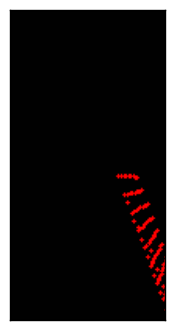

In [20]:
# Función para pintar los puntos proyectados por la cámara real y la estimada
def draw_points(real_points, estimated_points):
    # creamos una imagen vacía
    img = np.ones(shape=(200,100,3), dtype=np.uint8)
    rp = np.array(150*real_points, dtype=np.int32)
    ep = np.array(150*estimated_points, dtype=np.int32)
    # pintamos los distintos puntos
    for i in range(real_points.shape[0]):
        cv2.circle(img=img, radius= 1, center=(rp[i,0], rp[i,1]), \
                   color=(255,0,0), thickness=-1)
        cv2.circle(img=img, radius=1, center=(ep[i, 0], ep[i, 1]), \
                   color=(0, 0, 255), thickness=-1)
    mostrar(img)
    
draw_points(real_points=c, estimated_points=proyecta_puntos_en_plano(camara=dlt,puntos=p))

En la imagen sólo vemos puntos rojos ya al truncar a entero los puntos proyectados con ambas cámaras obtenemos las mismas coordenadas. Por tanto, los puntos proyectados por la cámara estimada se pintan encima de los puntos estimados por la cámara simulada, obteniendo este resultado. Esta imagen es la prueba de que la cámara estimada obtenida es una buena estimación de la cámara original.